In [7]:

import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elloyd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/elloyd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/elloyd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# Load training data
train_df = pd.read_csv("data/twitter_training.csv", header=None)
train_df.columns = ['id', 'entity', 'sentiment', 'text']
train_df = train_df.drop_duplicates(subset='text').reset_index(drop=True)
valid_labels = ['Positive', 'Negative', 'Neutral']
df = train_df[train_df['sentiment'].isin(valid_labels)].copy()



In [9]:
# Preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', str(text).lower())
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Preprocess training data
df['cleaned'] = df['text'].apply(preprocess_text)




TF-IDF Matrix Sample:
   abandon  ability  able  absolute  absolutely   ac  access  accidentally  \
0      0.0      0.0   0.0       0.0         0.0  0.0     0.0           0.0   
1      0.0      0.0   0.0       0.0         0.0  0.0     0.0           0.0   
2      0.0      0.0   0.0       0.0         0.0  0.0     0.0           0.0   
3      0.0      0.0   0.0       0.0         0.0  0.0     0.0           0.0   
4      0.0      0.0   0.0       0.0         0.0  0.0     0.0           0.0   

   according  account  ...  yet   yo  young  youtu  youtube   yu  zero  \
0        0.0      0.0  ...  0.0  0.0    0.0    0.0      0.0  0.0   0.0   
1        0.0      0.0  ...  0.0  0.0    0.0    0.0      0.0  0.0   0.0   
2        0.0      0.0  ...  0.0  0.0    0.0    0.0      0.0  0.0   0.0   
3        0.0      0.0  ...  0.0  0.0    0.0    0.0      0.0  0.0   0.0   
4        0.0      0.0  ...  0.0  0.0    0.0    0.0      0.0  0.0   0.0   

   zombie  zone  zoom  
0     0.0   0.0   0.0  
1     0.0   0.0 

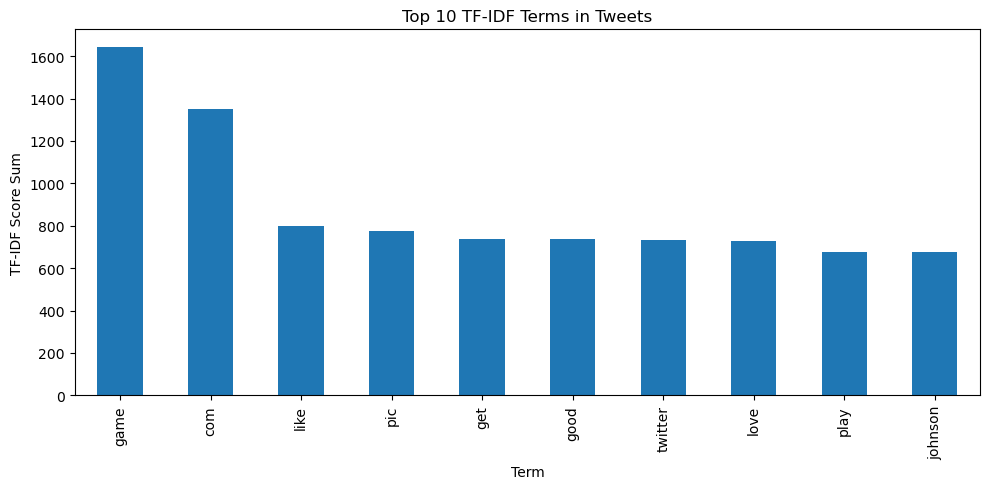

In [10]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['cleaned'])
y = df['sentiment']

# View TF-IDF matrix as DataFrame
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print("TF-IDF Matrix Sample:")
print(tfidf_df.head())

# Plot top 10 TF-IDF terms
term_sums = tfidf_df.sum(axis=0).sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
term_sums.plot(kind='bar')
plt.title("Top 10 TF-IDF Terms in Tweets")
plt.xlabel("Term")
plt.ylabel("TF-IDF Score Sum")
plt.tight_layout()
plt.show()



In [11]:
# Train-test split and train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate on test set
y_pred = clf.predict(X_test)
print("\nClassification Report on Training Split:")
print(classification_report(y_test, y_pred))




Classification Report on Training Split:
              precision    recall  f1-score   support

    Negative       0.90      0.92      0.91      6350
     Neutral       0.93      0.87      0.89      5113
    Positive       0.87      0.91      0.89      5720

    accuracy                           0.90     17183
   macro avg       0.90      0.90      0.90     17183
weighted avg       0.90      0.90      0.90     17183



In [12]:
# ---- Validation Set Evaluation ----
val_df = pd.read_csv("data/twitter_validation.csv", header=None)
val_df.columns = ['id', 'entity', 'sentiment', 'text']
val_df = val_df[val_df['sentiment'].isin(valid_labels)].copy()
val_df['cleaned'] = val_df['text'].apply(preprocess_text)

# Vectorize and predict
X_val = vectorizer.transform(val_df['cleaned'])
y_val = val_df['sentiment']
y_val_pred = clf.predict(X_val)

print("\nValidation Set Evaluation:")
print(classification_report(y_val, y_val_pred))


Validation Set Evaluation:
              precision    recall  f1-score   support

    Negative       0.94      0.94      0.94       266
     Neutral       0.94      0.93      0.93       285
    Positive       0.94      0.94      0.94       277

    accuracy                           0.94       828
   macro avg       0.94      0.94      0.94       828
weighted avg       0.94      0.94      0.94       828



Interpretation:
The classifier is performing quite well, especially given the three-class problem.
Neutral had slightly lower recall (0.87), meaning it missed more Neutral examples than the others.
Balanced F1-scores (~0.89–0.91) across classes suggest the model isn’t overly favoring any one class.
90% accuracy is strong, especially considering potential label ambiguity in sentiment (Neutral vs Positive can be subtle).


Interpretation:
These are excellent results on unseen data.
F1-scores are slightly better than on the training split, which can happen if:
The validation set is slightly easier (more cleanly separated)
The training set contains more ambiguous or noisy labels
Generalization looks strong — the model’s not just memorizing, it’s learning real signal.
